В этом соревновании предложен датасет, содержащий сведения о ресторанах. С помощью имеющего кода, необходимо создать модель, использующую алгоритм RandomForestRegression, которая будет прогнозировать рейтинг ресторана по версии TripAdvidor.

Для победы в конкурсе необходимо качественно очистить датасет, подобрать подходящие значения для заполнения пропусков и создать новые признаки на основе той информации, которую вы сможете извлечь из имеющихся в вашем распоряжении данных.

Перед финальной подготовкой признаков для ml была проделана следующая работа:
- По всем ресторанам были "спарсены" данные (и те которые есть, и дополнительные)  
Парсер вынесен в отдельный файл (parser.py), запускался на нескольких удаленных серверах для увеличения скорости парсинга.
Сервера на дебиан. Парсер был запущен в фоновом режиме (nohup python3 parser.py &)  
Далее все данные были объеденены в один файл (parsed.csv)
- На втором этапе была проведена предвариельная подготовка данных (preprocessing.ipynb).
Здесь дополнял пропуски спарсенными данными. Если не хватало данных производил иную обработку пропусков. Также были добавлены новые признаки.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



import warnings
warnings.filterwarnings('ignore')

In [5]:
# Зафиксируем будущие эксперименты
RANDOM_SEED = 42

In [6]:
# Загрузим итоговые данные и проведем EDA (Разведочный анализ данных)
df = pd.read_csv(r'all_in.csv')
df.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,ID_TA,Main,alive,...,rest_number,is_capital,cuisines_number,population,city_square,net_rest,negative,neutra,positive,compound
14923,id_10163,London,['Mediterranean'],10172.0,4.0,$,9.0,d10025740,True,1,...,17511.0,1,1,8908081,1572.0,0,0.000,0.642,0.358,0.5994
27369,id_12219,London,"['Italian', 'Pizza']",12229.0,3.5,$$ - $$$,19.0,d12973646,True,1,...,17511.0,1,2,8908081,1572.0,1,0.193,0.566,0.241,0.1280


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      50000 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        50000 non-null  object 
 6   Number of Reviews  50000 non-null  float64
 7   ID_TA              50000 non-null  object 
 8   Main               50000 non-null  bool   
 9   alive              50000 non-null  int64  
 10  rating             50000 non-null  float64
 11  excelent           50000 non-null  float64
 12  very_good          50000 non-null  float64
 13  average            50000 non-null  float64
 14  poor               50000 non-null  float64
 15  terrible           50000 non-null  float64
 16  time_between       500

Restaurant_id - ID ресторана  
City - город, в котором расположен ресторан  
Cuisine Style - типы кухонь, которые подаются в ресторане  
Ranking - абсолютная позиция ресторана среди прочих ресторанов города  
Rating - рейтниг ресторана (наша целевая переменная)  
Price Range - уровень цен в ресторане  
Number of Reviews - кол-во отзывов о ресторане  
ID_TA - ID ресторана на сайте Tripadviser  
Main - признак, к какому датасету относятся данные (1 - основная выборка, 0 - валидационная  
alive - живой\неживой ресторан (есть на текущий момент инфа на Трипэдвайзер или нет  
rating - спарсенный рейтинг ресторанов  
'excelent', 'very_good', 'average', 'poor', 'terrible' - кол-во отзывов разного качества  
time_between - время между последними двумя отзывами  
last_time_review - время с последнего отзыва  
text_reviews - текст отзывов
is_capital - является ли город столицей или нет  
cuisines_number - кол-во кухонь в ресторане  
population - население в городе  
city_square - площадь в городе  
rest_number - кол-во ресторанов в городе  
net_rest - является ресторан уникальным (сетевым) или нет
negative, neutra, positive, compound - вероятность отнесения отзыва к положительному или негативному (или нейтральному)

In [8]:
# Разобьем признаки на категориальные, числовые и бинарные. (некоторые - условно, их нужно еще доработать)
num_features = ['Number of Reviews', 'time_between', 'last_time_review', \
                'cuisines_number', 'population', 'city_square', 'Ranking', 'rating', 'rest_number',\
                'excelent', 'very_good', 'average', 'poor', 'terrible', \
                'negative', 'neutra', 'positive', 'compound']

cat_features = ['City', 'Cuisine Style', 'Price Range', 'text_reviews']
bin_features = ['alive', 'is_capital', 'net_rest']

other_features = ['Restaurant_id', 'ID_TA', 'Main', ]

 ### Числовые признаки
 ##### 'Number of Reviews'

count    50000.000000
mean       116.720620
std        286.112464
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64


<AxesSubplot:>

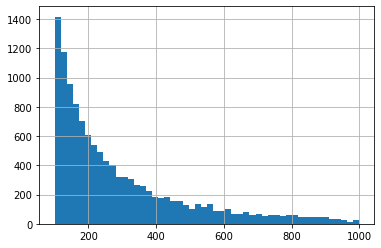

In [9]:
# Кол-во отзывов о ресторане
print(df['Number of Reviews'].describe())
df[(df['Number of Reviews'] > 100) & (df['Number of Reviews'] < 1000)]['Number of Reviews'].hist(bins=50)

<AxesSubplot:>

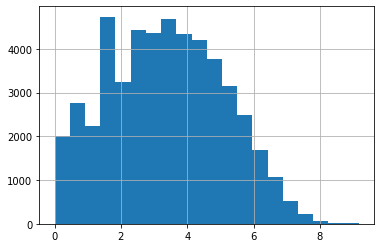

In [10]:
# Много ресторанов с маленьким количеством отзывов и наоборот мало с большим.
# Чтобы сгладить применим log
df['Number of Reviews'] = df['Number of Reviews'].apply(lambda x: np.log(x) if x != 0 else x)
df['Number of Reviews'].hist(bins=20)
# стало намного симпатичнее и ближе к норм распределению

##### 'time_between'

count    50000.000000
mean      2027.352160
std       5345.107678
min          0.000000
25%          7.000000
50%         59.000000
75%        223.000000
max      17585.000000
Name: time_between, dtype: float64


<AxesSubplot:>

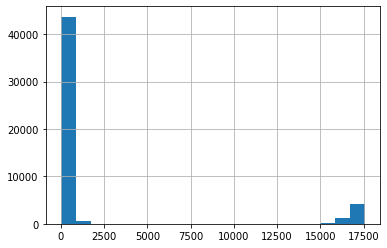

In [11]:
# время между отзывами
print(df['time_between'].describe())
#df[df['time_between'] < 0]['time_between'].hist(bins=20)
df['time_between'].hist(bins=20)


<AxesSubplot:>

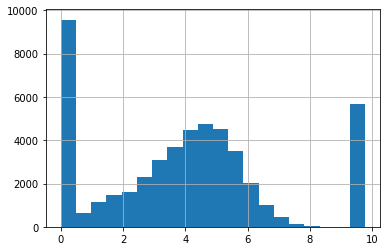

In [12]:
# сгладим этот некрасивый график логарифмом
df['time_between'] = df['time_between'].apply(lambda x: np.log(x) if x != 0 else x)
df['time_between'].hist(bins=20)

##### 'last_time_review'

count    50000.000000
mean      4687.608640
std       6383.689645
min       1584.000000
25%       1681.000000
50%       1809.000000
75%       2263.000000
max      19172.000000
Name: last_time_review, dtype: float64


<AxesSubplot:>

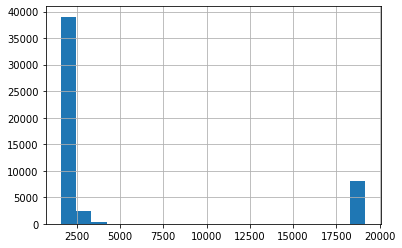

In [13]:
# время после последнего отзыва
print(df['last_time_review'].describe())
df['last_time_review'].hist(bins=20)

<AxesSubplot:>

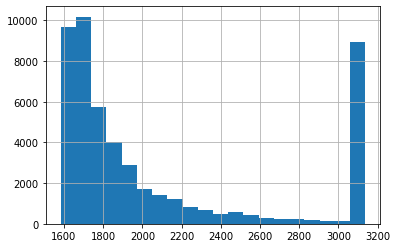

In [14]:
perc25 = df['last_time_review'].quantile(0.25)
perc75 = df['last_time_review'].quantile(0.75)
IQR = perc75 - perc25

df['last_time_review'] = df['last_time_review'].apply(lambda x : x if x < perc75 + 1.5*IQR else perc75 + 1.5*IQR)
df['last_time_review'].hist(bins=20)

<AxesSubplot:>

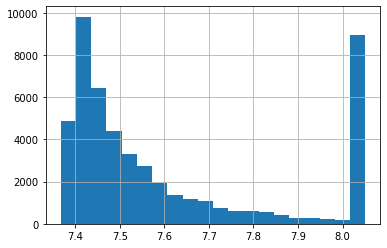

In [15]:
# сгладим этот некрасивый график логарифмом
df['last_time_review'] = df['last_time_review'].apply(lambda x: np.log(x) if x != 0 else x)
df['last_time_review'].hist(bins=20)
# распределение далеко от нормального. Посмотрим, возможно, в дальнейшем избавимся от данного столбца.

##### 'cuisines_number'

count    50000.000000
mean         2.709720
std          1.785744
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: cuisines_number, dtype: float64


<AxesSubplot:>

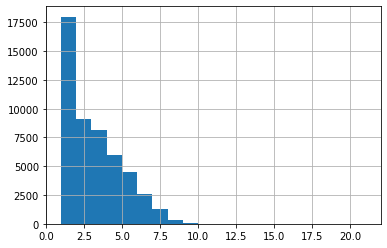

In [16]:
# количество кухонь в ресторане
print(df['cuisines_number'].describe())
df['cuisines_number'].hist(bins=20)

<AxesSubplot:>

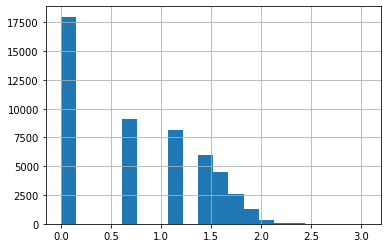

In [17]:
# сгладим этот некрасивый график логарифмом
df['cuisines_number'] = df['cuisines_number'].apply(lambda x: np.log(x) if x != 0 else x)
df['cuisines_number'].hist(bins=20)

Нерассмотренными остались 'population', 'city_square', Ranking, rest_number и rating.  
Логика подсказывает, что сами по себе population и squre не являются числовыми признаками, а в некотором роде являтся категорильными, как и город - City. но мы можем получить из них относительные признаки типа, Rankig/population, Ranking/square  Ranking/rest_number  
Сам Ranking - тоже условный показатель. Одно дело находится на 1000 месте среди 10 000 ресторанов и другое быть 10 из 10.  
rating - в свою очередь немного читовый признак, так как он по сути является целевой переменной.  

<AxesSubplot:>

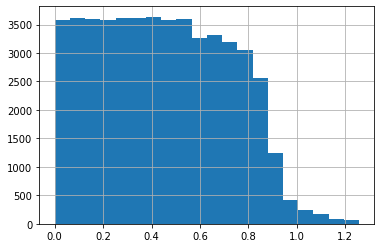

In [18]:
# добавим несколько признаков
# место ресторана в общем кол-ве ресторанов города
df['rest_in_rests'] = df['Ranking']/df['rest_number']
df['rest_in_rests'].hist(bins=20)

<AxesSubplot:>

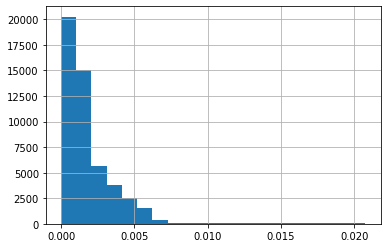

In [19]:
# место ресторана в населении города
df['rest_in_pop'] = df['Ranking']/df['population']
df['rest_in_pop'].hist(bins=20)

<AxesSubplot:>

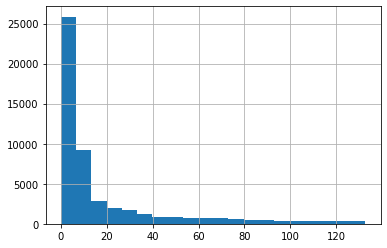

In [20]:
# место ресторана в площади города
df['rest_in_sq'] = df['Ranking']/df['city_square']
df['rest_in_sq'].hist(bins=20)

##### 'city_square'

count    50000.000000
mean       556.243029
std        546.678679
min         15.930000
25%        105.400000
50%        368.000000
75%        891.680000
max       2586.400000
Name: city_square, dtype: float64


<AxesSubplot:>

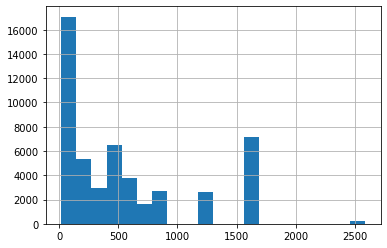

In [21]:
# площадь города
print(df['city_square'].describe())
df['city_square'].hist(bins=20)

##### rating

count    50000.00000
mean         3.96267
std          0.54709
min          1.00000
25%          4.00000
50%          4.00000
75%          4.00000
max          5.00000
Name: rating, dtype: float64


<AxesSubplot:>

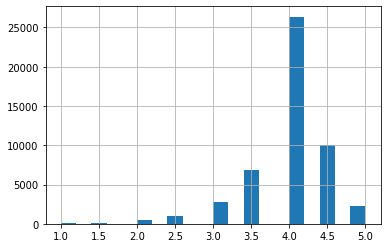

In [22]:
# rating - спарсенный рейтинг ресторанов (Nan были заменены медианой)
print(df['rating'].describe())
df['rating'].hist(bins=20)


<AxesSubplot:>

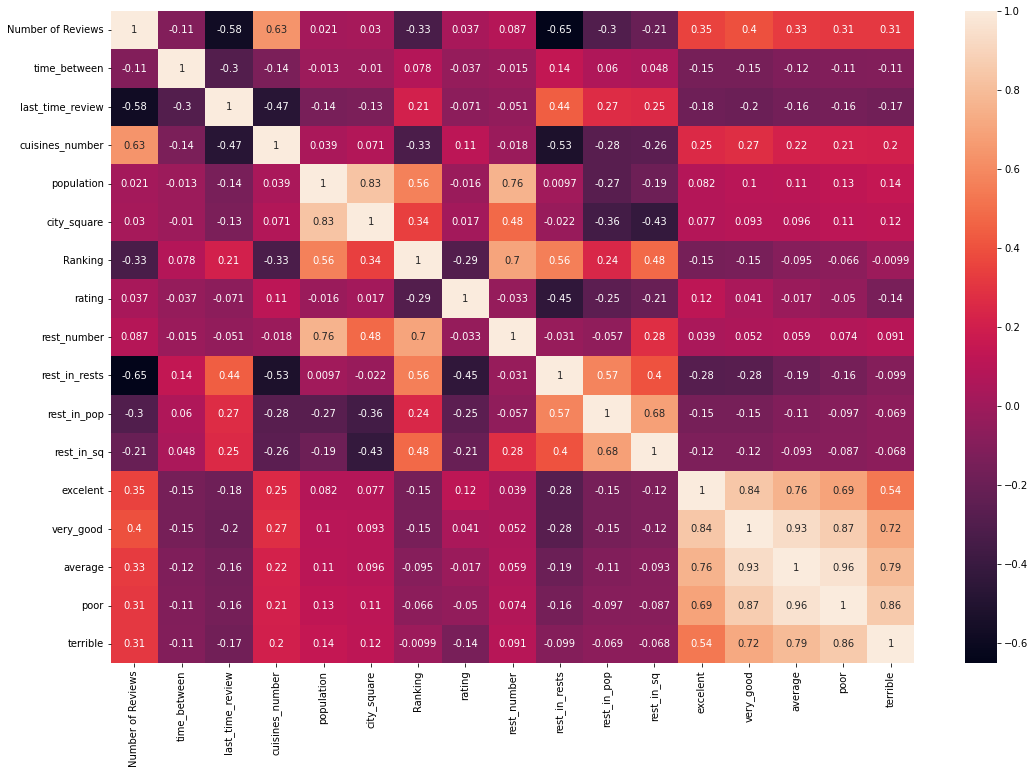

In [23]:
# итак числовые признаки:
num_features = ['Number of Reviews', 'time_between', 'last_time_review', \
                'cuisines_number', 'population', 'city_square', 'Ranking', 'rating', 'rest_number', \
                'rest_in_rests', 'rest_in_pop', 'rest_in_sq', 'excelent', 'very_good', 'average', 'poor', 'terrible']

# Посмотрим матрицу корреляций
correlation_matrix = df[num_features].corr()

# выведем на тепловую карту
plt.figure(figsize=(18,12))
sns.heatmap(correlation_matrix, annot=True)

Как видим, наличие высокой корреляции между собой признаков Population, City_square, rest_number.  
При этом у данных признаков низкая корреляция с rating


#### Теперь перейдем к категориальным признакам

К категориальным признакам относим следующие:  
- 'City' город, в котором находится ресторан  
- 'Cuisine Style' - тип кухни  
- 'Price Range' - Уровень цен  
 
в т.ч.
бинарные
- 'alive' - живой/неживой (есть или нет на Трипэдвайзере)  
- 'is_capital' ресторан в столице или нет  
- 'net_rest' - уникальность ресторана (сетевой или нет)


In [24]:
cat_features = ['City', 'Cuisine Style', 'Price Range']
bin_features = ['alive', 'is_capital', 'net_rest']

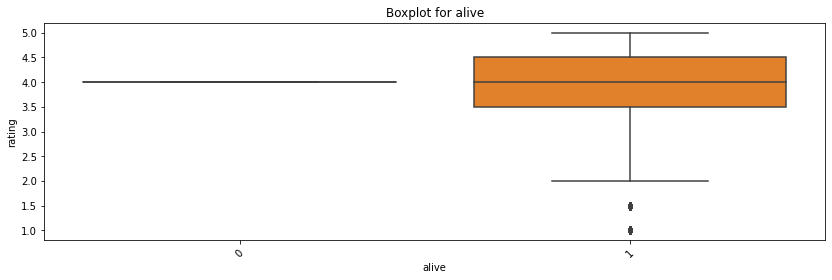

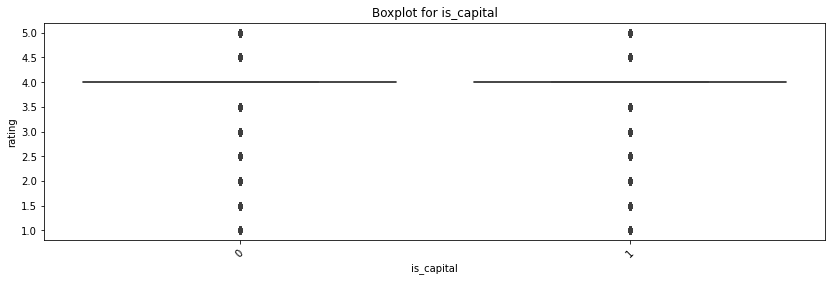

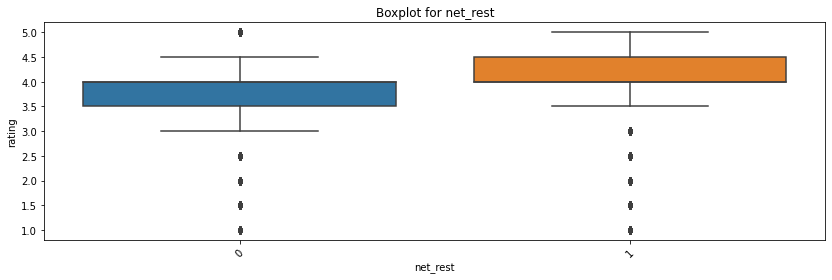

In [25]:
#Посмотрим боксплоты у бинарных признаков
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='rating', 
                data=df[df[column].isin(df[column].value_counts().index[:])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in bin_features:
    get_boxplot(col)

#### Теперь посмотрим на категориальные признаки (с несколькими категориями)


In [26]:
# Сделаем столбцы из категориальных признаков
df = pd.get_dummies(df, columns=['City', 'Price Range'])

In [27]:
# С Cuisine Style чуть сложнее. Переведем в списки, добавим столбцы, заполним по наличию кухни в списке
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x[2:-2].split("', '"))
cuisines_list = []
for cuisines in df['Cuisine Style']:
    for cuisine in cuisines: 
        if cuisine not in cuisines_list:
            cuisines_list.append(cuisine)

for cuisine in cuisines_list:
    df = df.reindex(columns = np.append(df.columns.values, [cuisine]))


for cuisine in cuisines_list:    
    df[cuisine] = df['Cuisine Style'].apply(lambda x: 1 if cuisine in x else 0)

In [36]:
with pd.option_context('display.max_columns', None):
    display(df.sample(2))

#### Подготовка данных для модели

In [29]:
# оставляем в табличке для теста только рабочие столбцы 
df_for_test = df.drop(['Restaurant_id', 'Cuisine Style', 'ID_TA', 'text_reviews', 'Rating'], axis = 1)
scaler = MinMaxScaler()
df_for_test[num_features] = scaler.fit_transform(df_for_test[num_features])


# Готовим данные
X = df_for_test[df_for_test['Main']]
y = df[df['Main']]['Rating']

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 20% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### Model

In [30]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [31]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17276249999999999


In [32]:
# Округлим результаты работы модели:
def round_to_polovina(row):
    return (round(row*2.0)/2)

new_round = np.vectorize(round_to_polovina)
y_pred_round = new_round(model.predict(X_test))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


MAE: 0.1393125


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


<AxesSubplot:>

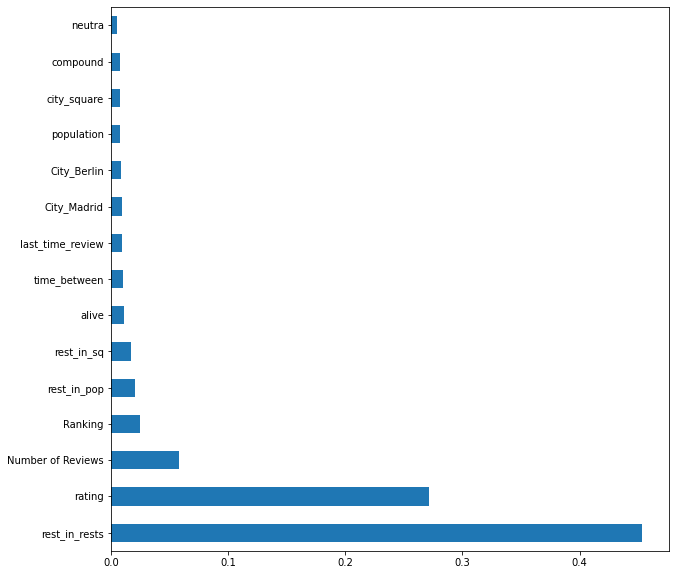

In [33]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

#### Результаты для  Kaggle

In [34]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
kaggle_df = df_for_test[~df_for_test['Main']]
y_pred = model.predict(kaggle_df)

submission = pd.DataFrame({
        "Restaurant_id": df[~df['Main']]['Restaurant_id'],
        "Rating": y_pred
    })
#submission['Restaurant_id']=submission['Restaurant_id'].astype('str')

submission['Rating'] = submission['Rating'].apply(round_to_polovina)
submission.to_csv('submission.csv', index=False)
submission

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


,Restaurant_id,Rating
3441,id_1423,4.0
5093,id_4337,3.5
5553,id_4323,4.0
6034,id_7376,5.0
11346,id_704,3.5
...,...,...
49995,id_9995,4.5
49996,id_9996,4.0
49997,id_9997,3.0
49998,id_9998,4.5
